# Make Dataset

The purpose of this notebook is primarily to prototype and visualize code to be used in `makeDataset.py`.

In [19]:
import tensorflow as tf
import pandas as pd
import numpy as np
from glob import glob
from multiprocessing import Process
import matplotlib.pyplot as plt
from scipy import signal
from tqdm.notebook import tqdm
import gwpy
from gwpy.timeseries import TimeSeries

In [20]:
INPUT_DIR = "../input/g2net-gravitational-wave-detection"
train_df = pd.read_csv(f"{INPUT_DIR}/training_labels_paths.csv")
test_df = pd.read_csv(f"{INPUT_DIR}/test_paths.csv")
savedir = "../input/whitened-tfrec"

## Main Data Pre-Processing Pipeline

In [ ]:
def bandpass(x, lf=20, hf=500, order=8, sr=2048):
    sos = signal.butter(order, [lf,hf], btype="bandpass", output="sos",fs=sr)
    normalization = np.sqrt((hf-lf) / (sr/2))
    if x.ndim == 2:
        for i in range(3):
            x[i] = signal.sosfilt(sos,x[i]) * normalization
    elif x.ndim == 3:
        for i in range(x,shape[0]):
            for j in range(3):
                x[i,j] = signal.sosfilt(sos,x[i,j]) * normalization
    return x

In [22]:
def prepare_wave(wave):
    wave = np.load(train_df.path[0])
    normalized_waves = []
    scaling = np.array([1.5e-20,1.5e-20,0.5e-20], dtype = np.float32)
    for i in range(3):
        normalized_wave = wave[i] / scaling[i]
        normalized_waves.append(normalized_wave)
    wave = np.stack(normalized_waves, axis=0)
    print(wave)
    return wave

In [212]:
def highpass(x, lf=20, order=128, sr=2048):
    sos = signal.butter(order, lf, btype="highpass", output="sos", fs=sr)
    normalization = np.sqrt((2048-lf) / (sr/2))
    if x.ndim == 2:
        for i in range(3):
            x[i] = signal.sosfilt(sos,x[i]) * normalization
    elif x.ndim == 3:
        for i in range(x,shape[0]):
            for j in range(3):
                x[i,j] = signal.sosfilt(sos,x[i,j]) * normalization
    return x

In [213]:
def save_files(rg_n, df=train_df):
    all_data_x = np.zeros([len(rg_n),4096,3], dtype=np.float32)
    all_data_y = np.zeros(len(rg_n), dtype=np.uint8)
#     filts=[]
    # for j in range(3):
        # bp = filter_design.bandpass(50,550, 2048)
#         if j == 2:
#             notch_freqs = (50, 100, 150)
#         else:
#             notch_freqs = (60, 120, 180)
#         notches = [filter_design.notch(line, 2048) for line in notch_freqs]
#         zpk = filter_design.concatenate_zpks(bp, *notches)
#         filts.append(zpk)
    print(rg_n)
    slc = df.iloc[rg_n]
    print(slc.head())
    ids = []

    for index in tqdm(range(slc.shape[0])):
        pth, ident, target = slc.iloc[index][["path", "id", "target"]]
        ids.append(ident)
        all_data_y[index] = target
        ts_data = np.load(pth)

        ts_data = prepare_wave(ts_data)

        #ts_data = bandpass(ts_data)
        
        for i in range(3):
            measurement = ts_data[i]
            ts = TimeSeries(measurement)
            ts.sample_rate = 2048


# #             zpk = filts[i]
# # #             ts = ts.filter(zpk, filtfilt=True)
#             ts = ts.whiten(1., 0.9999)
            ts_data[i] = np.array(ts)
        ts_data = highpass(ts_data)
        
        ts_data = np.transpose(ts_data, [1,0])
#         ts_data[0:512] = 0
#         ts_data[-256:] = 0
#         ts_data /= abs(ts_data).max()
#         ts_data = ts_data * -1
        ts_data = ts_data.astype(np.float32)
        all_data_x[index] = ts_data


    return all_data_x, all_data_y, ids

In [214]:
results = save_files(range(100))

range(0, 100)
           id  target                                               path
0  00000e74ad       1  ../input/g2net-gravitational-wave-detection/tr...
1  00001f4945       0  ../input/g2net-gravitational-wave-detection/tr...
2  0000661522       0  ../input/g2net-gravitational-wave-detection/tr...
3  00007a006a       0  ../input/g2net-gravitational-wave-detection/tr...
4  0000a38978       1  ../input/g2net-gravitational-wave-detection/tr...


  0%|          | 0/100 [00:00<?, ?it/s]

[[-0.39655371 -0.38999698 -0.36161012 ... -0.404466
  -0.39756383 -0.3838523 ]
 [ 0.06502714  0.03017241  0.00305763 ... -0.73072141
  -0.7317776  -0.73905422]
 [-0.34974398 -0.23657359 -0.38644757 ...  0.29300455
   0.43728974  0.30817188]]
[[-0.39655371 -0.38999698 -0.36161012 ... -0.404466
  -0.39756383 -0.3838523 ]
 [ 0.06502714  0.03017241  0.00305763 ... -0.73072141
  -0.7317776  -0.73905422]
 [-0.34974398 -0.23657359 -0.38644757 ...  0.29300455
   0.43728974  0.30817188]]
[[-0.39655371 -0.38999698 -0.36161012 ... -0.404466
  -0.39756383 -0.3838523 ]
 [ 0.06502714  0.03017241  0.00305763 ... -0.73072141
  -0.7317776  -0.73905422]
 [-0.34974398 -0.23657359 -0.38644757 ...  0.29300455
   0.43728974  0.30817188]]
[[-0.39655371 -0.38999698 -0.36161012 ... -0.404466
  -0.39756383 -0.3838523 ]
 [ 0.06502714  0.03017241  0.00305763 ... -0.73072141
  -0.7317776  -0.73905422]
 [-0.34974398 -0.23657359 -0.38644757 ...  0.29300455
   0.43728974  0.30817188]]
[[-0.39655371 -0.38999698 -0.361

[[-0.39655371 -0.38999698 -0.36161012 ... -0.404466
  -0.39756383 -0.3838523 ]
 [ 0.06502714  0.03017241  0.00305763 ... -0.73072141
  -0.7317776  -0.73905422]
 [-0.34974398 -0.23657359 -0.38644757 ...  0.29300455
   0.43728974  0.30817188]]
[[-0.39655371 -0.38999698 -0.36161012 ... -0.404466
  -0.39756383 -0.3838523 ]
 [ 0.06502714  0.03017241  0.00305763 ... -0.73072141
  -0.7317776  -0.73905422]
 [-0.34974398 -0.23657359 -0.38644757 ...  0.29300455
   0.43728974  0.30817188]]
[[-0.39655371 -0.38999698 -0.36161012 ... -0.404466
  -0.39756383 -0.3838523 ]
 [ 0.06502714  0.03017241  0.00305763 ... -0.73072141
  -0.7317776  -0.73905422]
 [-0.34974398 -0.23657359 -0.38644757 ...  0.29300455
   0.43728974  0.30817188]]
[[-0.39655371 -0.38999698 -0.36161012 ... -0.404466
  -0.39756383 -0.3838523 ]
 [ 0.06502714  0.03017241  0.00305763 ... -0.73072141
  -0.7317776  -0.73905422]
 [-0.34974398 -0.23657359 -0.38644757 ...  0.29300455
   0.43728974  0.30817188]]
[[-0.39655371 -0.38999698 -0.361

[[-0.39655371 -0.38999698 -0.36161012 ... -0.404466
  -0.39756383 -0.3838523 ]
 [ 0.06502714  0.03017241  0.00305763 ... -0.73072141
  -0.7317776  -0.73905422]
 [-0.34974398 -0.23657359 -0.38644757 ...  0.29300455
   0.43728974  0.30817188]]
[[-0.39655371 -0.38999698 -0.36161012 ... -0.404466
  -0.39756383 -0.3838523 ]
 [ 0.06502714  0.03017241  0.00305763 ... -0.73072141
  -0.7317776  -0.73905422]
 [-0.34974398 -0.23657359 -0.38644757 ...  0.29300455
   0.43728974  0.30817188]]
[[-0.39655371 -0.38999698 -0.36161012 ... -0.404466
  -0.39756383 -0.3838523 ]
 [ 0.06502714  0.03017241  0.00305763 ... -0.73072141
  -0.7317776  -0.73905422]
 [-0.34974398 -0.23657359 -0.38644757 ...  0.29300455
   0.43728974  0.30817188]]
[[-0.39655371 -0.38999698 -0.36161012 ... -0.404466
  -0.39756383 -0.3838523 ]
 [ 0.06502714  0.03017241  0.00305763 ... -0.73072141
  -0.7317776  -0.73905422]
 [-0.34974398 -0.23657359 -0.38644757 ...  0.29300455
   0.43728974  0.30817188]]
[[-0.39655371 -0.38999698 -0.361

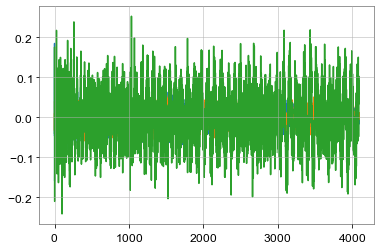

In [215]:
plt.plot(results[0][18])

## `tfrec` creation

In [35]:
 

def make_tfrec_train(batches, batch_size): 
    for i in tqdm(range(batches)):
        rg_n = range(i*batch_size,(i+1)*batch_size)
        output_file = f"{savedir}/train_whitened_{i:02}.tfrec"
        if glob(output_file) != []:
            print(f"skipping {i}")
            continue
        else:
            print(f"doing {i}")
    #         rng = (range(i * batch_size, (i+1)*batch_size))
            tr_x, tr_y, ids = save_files(rg_n, train_df)
            writer = tf.io.TFRecordWriter(output_file)
            for i in tqdm(range(tr_x.shape[0])):
                X = tr_x[i]
                y = tr_y[i]
                ident = str.encode(ids[i])

                # Feature contains a map of string to feature proto objects
                feature = {}
                feature["TimeSeries"] = tf.train.Feature(float_list=tf.train.FloatList(value=X.flatten()))
                feature["id"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[ident]))
                feature["Target"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[y]))

                #contruct the Example proto object
                example = tf.train.Example(features=tf.train.Features(feature=feature))
                serialized = example.SerializeToString()

                # write the serialized object to disk
                writer.write(serialized)
            writer.close()

In [13]:
batches = 16
batch_size = train_df.shape[0] // batches
if __name__ == "__main__":
    for _ in range(batches):
        p = Process(target=make_tfrec_train, args = (batches, batch_size))
        p.start()
        p.join()
else:
    print("name not main")

In [11]:
batches = 1
batch_size = test_df.shape[0] // batches
for i in tqdm(range(batches)):
    rg_n = range(i*batch_size,(i+1)*batch_size)
    output_file = f"{savedir}/test_whitened_{i:02}.tfrec"
    if glob(output_file) != []:
        print(f"skipping {i}")
        continue
    else:
        print(f"doing {i}")
#         rng = (range(i * batch_size, (i+1)*batch_size))
        tr_x, tr_y, ids = save_files(rg_n, test_df)
#         tr_x = test[rg_n]
        writer = tf.io.TFRecordWriter(output_file)
        for i in tqdm(range(tr_x.shape[0])):
            X = tr_x[i]

            # Feature contains a map of string to feature proto objects
            feature = {}
            feature["TimeSeries"] = tf.train.Feature(float_list=tf.train.FloatList(value=X.flatten()))
            feature["id"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[ident]))

            #contruct the Example proto object
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            serialized = example.SerializeToString()

            # write the serialized object to disk
            writer.write(serialized)
        writer.close()

  0%|          | 0/1 [00:00<?, ?it/s]

doing 0
range(0, 226000)
           id  target                                               path
0  00005bced6     0.5  ../input/g2net-gravitational-wave-detection/te...
1  0000806717     0.5  ../input/g2net-gravitational-wave-detection/te...
2  0000ef4fe1     0.5  ../input/g2net-gravitational-wave-detection/te...
3  00020de251     0.5  ../input/g2net-gravitational-wave-detection/te...
4  00024887b5     0.5  ../input/g2net-gravitational-wave-detection/te...


  0%|          | 0/226000 [00:00<?, ?it/s]

  0%|          | 0/226000 [00:00<?, ?it/s]

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'feature'

In [ ]:
test = tr_x
test.shape